# Imports

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# from HANKModel import HANKModelClass
from HANKModel import create_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Q2: Compute the impact and cumulative multipliers in the RANK and the TANK model after a deficit-financed transfers 

### Solve for the steady-states

In [9]:
model_RANK = create_model(name='RANK', par={'HH_type' : 'RANK'})
model_TANK = create_model(name='TANK', par={'HH_type' : 'TANK'})
model_TANK.par.low_transfers = False
model_RANK.par.low_transfers = False

In [10]:
model_RANK.par.beta = 0.99
model_RANK.find_ss(do_print=False, x0=np.array([model_RANK.par.beta]))

steady state found in 0.0 secs
 beta =   0.9900
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000


In [11]:
model_TANK.par.beta = model_RANK.par.beta
model_TANK.find_ss(do_print=False, x0=np.array([model_TANK.par.beta]))

steady state found in 0.0 secs
 beta =   0.9900
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


### Compute the multipliers

In [12]:
discount = (1+model_RANK.ss.r)**(-np.arange(model_RANK.par.T))

In [13]:
def compute_linear_multipliers(model, discount=None):
    if discount is None:
        discount = (1 + model.ss.r)**(-np.arange(model.par.T))
    model.compute_jacs(do_print=False)
    model.find_IRFs(shocks=['transfers'], do_print=False)
    dY = model.IRF['Y']
    dT = model.IRF['transfers']
    impact = dY[0] / dT[0]
    cumulative = np.sum(discount * dY) / np.sum(discount * dT)
    return impact, cumulative

impact_multiplier_RANK, cumulative_multiplier_RANK = compute_linear_multipliers(model_RANK, discount)
print(f"RANK Impact Multiplier: {impact_multiplier_RANK:.2f}")
print(f"RANK Cumulative Multiplier: {cumulative_multiplier_RANK:.2f}")



RANK Impact Multiplier: 0.00
RANK Cumulative Multiplier: 0.00


In [14]:
discount_TANK = (1 + model_TANK.ss.r)**(-np.arange(model_TANK.par.T))
impact_multiplier_TANK, cumulative_multiplier_TANK = compute_linear_multipliers(model_TANK, discount_TANK)
print(f"TANK Impact Multiplier: {impact_multiplier_TANK:.2f}")
print(f"TANK Cumulative Multiplier: {cumulative_multiplier_TANK:.2f}")

TANK Impact Multiplier: 0.83
TANK Cumulative Multiplier: -0.00


## Q3: Impact and cumulative multipliers in HANK

### Solve for the steady-state

In [15]:
model_HANK = create_model(name='baseline', par={'HH_type' : 'HANK'})
model_HANK.par.low_transfers = False
model_HANK.par.B = 0.92
model_HANK.find_ss(do_print=False)

steady state found in 2.6 secs
 beta =   0.9757
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


### Compute multipliers

In [16]:
# solve for HANK multipliers here
impact_multiplier_HANK, cumulative_multiplier_HANK = compute_linear_multipliers(model_HANK)
print(f"HANK Impact Multiplier: {impact_multiplier_HANK:.2f}")
print(f"HANK Cumulative Multiplier: {cumulative_multiplier_HANK:.2f}")

HANK Impact Multiplier: 0.71
HANK Cumulative Multiplier: 1.04


### Multipliers during a large shock

In [17]:
model_HANK_large = model_HANK.copy()
large_shock_size = 0.10
model_HANK_large.par.jump_transfers = large_shock_size

# linear approximation with large shock
impact_multiplier_HANK_large, cumulative_multiplier_HANK_large = compute_linear_multipliers(model_HANK_large)

# non-linear approximation with large shock
model_HANK_large.find_transition_path(shocks=['transfers'], do_print=False, do_end_check=False)
discount_large = (1 + model_HANK_large.ss.r)**(-np.arange(model_HANK_large.par.T))
dY_large = model_HANK_large.path.Y[:, 0] - model_HANK_large.ss.Y
dT_large = model_HANK_large.path.transfers[:, 0] - model_HANK_large.ss.transfers
impact_multiplier_HANK_large_nonlin = dY_large[0] / dT_large[0]
cumulative_multiplier_HANK_large_nonlin = (discount_large @ dY_large) / (discount_large @ dT_large)

In [18]:
print(f"HANK Large Shock Impact Multiplier (Linear): {impact_multiplier_HANK_large:.2f}")
print(f"HANK Large Shock Cumulative Multiplier (Linear): {cumulative_multiplier_HANK_large:.2f}")
print(f"HANK Large Shock Impact Multiplier (Non-Linear): {impact_multiplier_HANK_large_nonlin:.2f}")
print(f"HANK Large Shock Cumulative Multiplier (Non-Linear): {cumulative_multiplier_HANK_large_nonlin:.2f}")

HANK Large Shock Impact Multiplier (Linear): 0.71
HANK Large Shock Cumulative Multiplier (Linear): 1.04
HANK Large Shock Impact Multiplier (Non-Linear): 0.27
HANK Large Shock Cumulative Multiplier (Non-Linear): 0.97


## Q4: Multiplier with high-liquidity

### Compute multipliers

In [19]:
model_RANK_hl = create_model(name='RANK', par={'HH_type' : 'RANK'})
model_RANK_hl.par.low_transfers = False
model_RANK_hl.par.B = 16.0
model_RANK_hl.par.r = model_RANK.par.r
model_RANK_hl.find_ss(do_print=False, x0=np.array([model_RANK.par.beta]))

discount_RANK_hl = (1 + model_RANK_hl.ss.r)**(-np.arange(model_RANK_hl.par.T))
impact_multiplier_RANK_hl, cumulative_multiplier_RANK_hl = compute_linear_multipliers(model_RANK_hl, discount_RANK_hl)
print(f"RANK Impact Multiplier: {impact_multiplier_RANK_hl:.2f}")
print(f"RANK Cumulative Multiplier: {cumulative_multiplier_RANK_hl:.2f}")


steady state found in 0.0 secs
 beta =   0.9900
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000
RANK Impact Multiplier: 0.00
RANK Cumulative Multiplier: 0.00


In [20]:
model_TANK_hl = create_model(name='TANK', par={'HH_type' : 'TANK'})
model_TANK_hl.par.low_transfers = False
model_TANK_hl.par.B = 16.0
model_TANK_hl.par.r = model_TANK.par.r
model_TANK_hl.find_ss(do_print=False, x0=np.array([model_TANK.par.beta]))

discount_TANK_hl = (1 + model_TANK_hl.ss.r)**(-np.arange(model_TANK_hl.par.T))
impact_multiplier_TANK_hl, cumulative_multiplier_TANK_hl = compute_linear_multipliers(model_TANK_hl, discount_TANK_hl)
print(f"TANK Impact Multiplier: {impact_multiplier_TANK_hl:.2f}")
print(f"TANK Cumulative Multiplier: {cumulative_multiplier_TANK_hl:.2f}")


steady state found in 0.0 secs
 beta =   0.9900
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000
TANK Impact Multiplier: 0.83
TANK Cumulative Multiplier: -0.00


In [21]:
model_HANK_hl = create_model(name='baseline', par={'HH_type' : 'HANK'})
model_HANK_hl.par.low_transfers = False
model_HANK_hl.par.B = 16.0
model_HANK_hl.par.r = model_HANK.par.r
model_HANK_hl.find_ss(do_print=False, x0=np.array([model_HANK.par.beta]))

discount_HANK_hl = (1 + model_HANK_hl.ss.r)**(-np.arange(model_HANK_hl.par.T))
impact_multiplier_HANK_hl, cumulative_multiplier_HANK_hl = compute_linear_multipliers(model_HANK_hl, discount_HANK_hl)
print(f"HANK Impact Multiplier: {impact_multiplier_HANK_hl:.2f}")
print(f"HANK Cumulative Multiplier: {cumulative_multiplier_HANK_hl:.2f}")


steady state found in 6.9 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
HANK Impact Multiplier: 0.06
HANK Cumulative Multiplier: 0.23


### Plot iMPCs

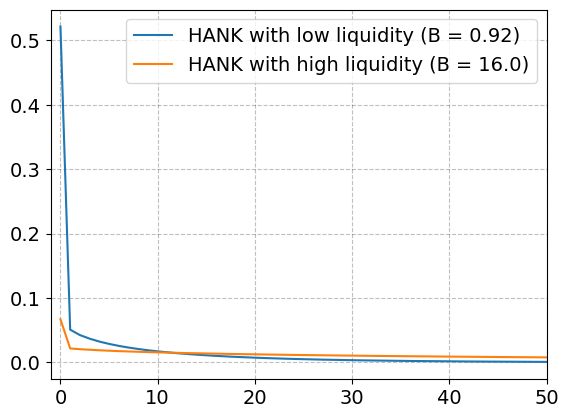

In [22]:
# compute iMPCs 
model_HANK.compute_jacs(do_print=False)
iMPC_low_liquidity = model_HANK.jac_hh[('C_hh', 'transfers')][:, 0]

model_HANK_hl.compute_jacs(do_print=False)
iMPC_high_liquidity = model_HANK_hl.jac_hh[('C_hh', 'transfers')][:, 0]

# Plot the first column of the iMPCs for transfers
plt.plot(iMPC_low_liquidity, label='HANK with low liquidity (B = 0.92)')
plt.plot(iMPC_high_liquidity, label='HANK with high liquidity (B = 16.0)')
plt.xlim(-1, 50)
plt.legend()
plt.show()


## Q5: Targeted transfers

In [23]:
model_HANK_target = create_model(name='baseline', par={'HH_type' : 'HANK'})
model_HANK_target.par.low_transfers = True
model_HANK_target.par.B = 16.0
model_HANK_target.par.r = model_HANK_hl.par.r
model_HANK_target.find_ss(do_print=False, x0=np.array([model_HANK_hl.par.beta]))

impact_multiplier_HANK_target, cumulative_multiplier_HANK_target = compute_linear_multipliers(model_HANK_target)
print(f"HANK Impact Multiplier: {impact_multiplier_HANK_target:.2f}")
print(f"HANK Cumulative Multiplier: {cumulative_multiplier_HANK_target:.2f}")


steady state found in 2.7 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
HANK Impact Multiplier: 0.09
HANK Cumulative Multiplier: 0.43


## Q6: Higher slope of NKPC

In [24]:
model_HANK_high_kappa = model_HANK_hl.copy()
model_HANK_high_kappa.par.kappa = 0.10
model_HANK_high_kappa.find_ss(do_print=False, x0=np.array([model_HANK_hl.par.beta]))

impact_multiplier_HANK_high_kappa, cumulative_multiplier_HANK_high_kappa = compute_linear_multipliers(model_HANK_high_kappa)
print(f"HANK High Kappa Impact Multiplier: {impact_multiplier_HANK_high_kappa:.2f}")
print(f"HANK High Kappa Cumulative Multiplier: {cumulative_multiplier_HANK_high_kappa:.2f}")


steady state found in 2.2 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
HANK High Kappa Impact Multiplier: 0.06
HANK High Kappa Cumulative Multiplier: 0.23
